# Problem 1 

## 1

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import dct, idct
import math

In [2]:
cameraman = Image.open('./cameraman.tif')

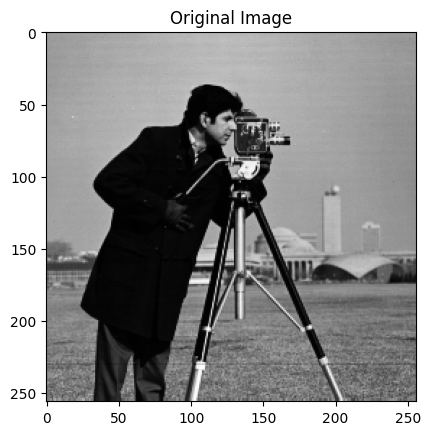

In [3]:
plt.imshow(cameraman, cmap = 'gray')
plt.title('Original Image')
plt.show()

In [4]:
image = np.array(cameraman)

In [5]:
image.shape

(256, 256)

In [6]:
def DCT(patch):
    return dct(dct(patch.T, norm='ortho').T, norm='ortho')

def INVDCT(patch):
    return idct(idct(patch.T, norm='ortho').T, norm='ortho')

In [7]:
def Quantize(Quant_Matrix, patch):
    return np.floor((patch / Quant_Matrix) + 0.5).astype(int)

def DeQuantize(Quant_Matrix, patch):
    return patch * Quant_Matrix

In [8]:
def Encode(patch):
    encoded_patch = ''
    flatten = patch.flatten()
    for element in flatten:
        if element == 0:
            encoded_patch += '0'
        else:
            no_of_bits = math.floor(math.log2(abs(element))) + 1
            prefix_code = ('1' * (no_of_bits)) + '0'
            if element < 0:
                element = element + (2**(no_of_bits) - 1)
                value_code = bin(element).replace('0b', '')
                value_code = ('0' * (no_of_bits - len(value_code))) + value_code               
            else:
                value_code = bin(element).replace('0b', '')
            element_code = prefix_code + value_code
            encoded_patch = encoded_patch + element_code
    return encoded_patch

In [9]:
def MeanSquareError(image1, image2):
    return np.mean((image1 - image2) ** 2)

In [10]:
def Compress(image, Quant_Matrix):
    
    block_size = Quant_Matrix.shape[0]
    height, width = image.shape
    num_blocks_h = height // block_size
    num_blocks_w = width // block_size
    # Loop over every block in the image
    Encoded_length = 0
    Compressed_image = np.zeros(image.shape)
    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            # Loop over every block in the image
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            # Compute DCT coefficients for block
            dct_block = DCT(block)
            # Quantize
            quantized_block = Quantize(Quant_Matrix, dct_block)
            # Encode
            encoded_block = Encode(quantized_block)
            Encoded_length += len(encoded_block)
            # Dequantize
            dequantized_block = DeQuantize(Quant_Matrix, quantized_block)
            # INV DCT
            invdct_block = INVDCT(dequantized_block)
            Compressed_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = invdct_block
    return Encoded_length, Compressed_image

In [11]:
Quant_Matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                         [12, 12, 14, 19, 26, 58, 60, 55],
                         [14, 13, 16, 24, 40, 57, 69, 56],
                         [14, 17, 22, 29, 51, 87, 80, 62],
                         [18, 22, 37, 56, 68, 109, 103, 77],
                         [24, 35, 55, 64, 81, 104, 113, 92],
                         [49, 64, 78, 87, 103, 121, 120, 101],
                         [72, 92, 95, 98, 112, 100, 103, 99]])

In [12]:
Encoded_bits, Compressed_image = Compress(image, Quant_Matrix)
input_bits = image.size * image.itemsize * 8
print('\033[1mInput Image Size in MB = ', input_bits / (8 * 1024 * 1024))
print('Compressed Image Size in MB = ', Encoded_bits / (8 * 1024 * 1024))
print('Compression Ratio =', input_bits / Encoded_bits)
print('MSE between Original and Compressed Images =', MeanSquareError(image, Compressed_image), '\033[0m')

Input Image Size in MB =  0.0625
Compressed Image Size in MB =  0.012904882431030273
Compression Ratio = 4.84312819849613
MSE between Original and Compressed Images = 44.54563508062465 


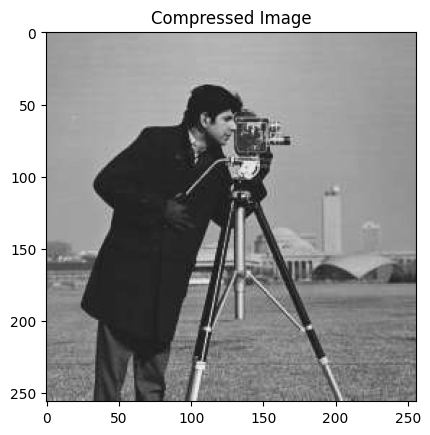

In [13]:
plt.imshow(Compressed_image, cmap = 'gray')
plt.title('Compressed Image')
plt.show()

## 2

In [14]:
Compressed_sizes = []
MSE = []

# Multiplying Quantization matrix with integers
for i in range(50, 0, -1):
    Quant = Quant_Matrix * i
    Encoded_length, Compressed_image = Compress(image, Quant)
    MSE.append(MeanSquareError(image, Compressed_image))
    Compressed_sizes.append(Encoded_length / (8 * 1024 * 1024))

# Dividing Quantization matrix with integers
for i in range(2, 51):
    Quant = Quant_Matrix / i
    Encoded_length, Compressed_image = Compress(image, Quant)
    MSE.append(MeanSquareError(image, Compressed_image))
    Compressed_sizes.append(Encoded_length / (8 * 1024 * 1024))

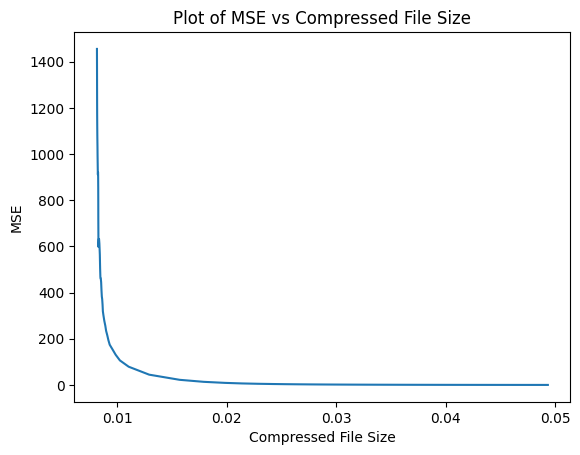

In [15]:
# Plot the two lists
plt.plot(Compressed_sizes, MSE)

# Add axis labels and a title
plt.xlabel('Compressed File Size')
plt.ylabel('MSE')
plt.title('Plot of MSE vs Compressed File Size')

# Show the plot
plt.show()